In [1]:
#thanks to @ambrosm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats as stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#e8e3e3' 
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0c7bdc'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][3:])
plt.rcParams['text.color'] = 'b'

INFERENCE = True # set to False if you only want to cross-validate

In [2]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [3]:
%%time
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14',\
                'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28',\
                'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41',  'D_39', 'D_41',\
                'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55',\
                'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73',\
                'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_92', 'D_96',\
                'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',\
                'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133',\
                'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1',\
                'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', \
                'R_22',  'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16',\
                'S_18', 'S_22', 'S_23', 'S_25', 'S_26', 'B_42','D_86','D_94','R_21','R_24']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28',\
                'B_29', 'B_36',  'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51',\
                'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_71', 'D_74', 'D_75', \
                'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132',\
                'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11',\
                'S_12', 'S_23', 'S_25','B_42','B_33', 'D_39', 'D_78','D_83','D_70','D_140']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15',\
                'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_37', 'B_38',\
                'B_40', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49',\
                'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71',\
                'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_102', 'D_105', 'D_107',\
                'D_110', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124',\
                'D_125', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138',  'D_141',\
                'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7','R_10', 'R_11', \
                'R_14',  'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', \
                'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27','B_42','B_39','D_91',  'R_8', 'D_136','D_140','D_111','D_126','D_135','B_33','R_17']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', \
                 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28',\
                 'B_29', 'B_30', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'D_39', 'D_41',\
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54',\
                 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71',\
                 'D_72',  'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80',  'D_82', 'D_83', 'D_86', 'D_91',\
                 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124',  \
                 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', \
                 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3',  'R_5', 'R_6', 'R_7', 'R_9', 'R_10',\
                 'R_11', 'R_12', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', \
                 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26',\
                 'S_27','B_32','B_41', 'B_42', 'D_73','D_81','D_125','D_126', 'R_4', 'R_14', 'R_8','R_13','R_15','R_19','S_6']
for i in ['test', 'train'] if INFERENCE else ['train']:
    df = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/{i}.parquet')
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)
    gc.collect()
    print('Read', i)
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    gc.collect()
    print('Computed avg', i)
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    print('Computed min', i)
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    print('Computed max', i)

    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    print('Computed last', i)
        
    #last["c_PB_29"]=(last["P_2_last"]*(-1)-.0001)/(last["B_9_last"]*(1)+0.0001)
    print('Computed extras', i)
    
    df = pd.concat([df, df_min, df_max,df_avg], axis=1)
    if i == 'train': train = df
    else: test = df
    print(f"{i} shape: {df.shape}")
    del df, df_avg, df_min, df_max, cid, last
    gc.collect()




    
target = pd.read_csv('../input/amex-default-prediction/train_labels.csv').target.values
print(f"target shape: {target.shape}")

Read test
Computed avg test
Computed min test
Computed max test
Computed last test
Computed extras test
test shape: (924621, 469)
Read train
Computed avg train
Computed min train
Computed max train
Computed last train
Computed extras train
train shape: (458913, 469)
target shape: (458913,)
CPU times: user 6min 8s, sys: 1min 27s, total: 7min 36s
Wall time: 7min 29s


In [4]:

# test['rand'] = np.random.rand(924621,1)
# train['rand'] = np.random.rand(458913,1)
#randoms came back with a 408 significance score, most of these vars aren't very helpful

#some of these vars beat the random so they are kept
test["c_DP_239"]=(test["D_39_last"]+.0001)/(test["P_2_last"]*(-1)+0.0001)
test["a_DP_239"]=(test["D_39_avg"]+.0001)/(test["P_2_avg"]*(-1)+0.0001)
test["c_PB_29"]=(test["P_2_last"]*(-1)+.0001)/(test["B_9_last"]*(1)+0.0001)
test["c_PR_21"]=(test["P_2_last"]*(-1)+.0001)/(test["R_1_last"]+0.0001)

test["c_DP_348"]=(test["D_48_last"]+.0001)/(test["P_3_last"]+0.0001)
test["c_DP_355"]=(test["D_55_last"]+.0001)/(test["P_3_last"]+0.0001)

test["c_DP_39r"]=(test["D_39_last"]+.0001)/(test["P_4_last"]+0.0001)
test["c_PB_49"]=(test["B_9_last"]+.0001)/(test["P_4_last"]+0.0001)
test["c_PR_41"]=(test["R_1_last"]+.0001)/(test["P_4_last"]+0.0001)
test["c_BB93"]=(test["B_9_last"]+0.001)/(test["B_23_last"]+test["B_3_last"]+0.0001)
test["c_BB1825"]=(test["B_33_last"]*(-1))+(test["B_18_last"]*(-1)+test["S_25_last"]*(1)+0.0001)
test["c_BB1920"]=(test["B_19_last"]+test["B_20_last"]+test["B_4_last"]+0.0001)

test["c_R3R2"]=(test["R_3_last"]+0.001)/(test["R_2_last"]+test["R_4_last"]+0.0001)
test["c_DDR6227"]=(test["D_62_last"]+0.001)/(test["D_112_last"]+test["R_27_last"]+0.0001)
print('^ Fixing those DataFrame fragmentation errors ^')
 
setter = test.copy()
del test
test = setter.copy()
del setter
gc.collect() 
print('Errors mitigated successfully, moving on...')
train["c_DP_239"]=(train["D_39_last"]+.0001)/(train["P_2_last"]*(-1)+0.0001)
train["a_DP_239"]=(train["D_39_avg"]+.0001)/(train["P_2_avg"]*(-1)+0.0001)
train["c_PB_29"]=(train["P_2_last"]*(-1)+.0001)/(train["B_9_last"]*(1)+0.0001)
train["c_PR_21"]=(train["P_2_last"]*(-1)+.0001)/(train["R_1_last"]+0.0001)

train["c_DP_348"]=(train["D_48_last"]+.0001)/(train["P_3_last"]+0.0001)
train["c_DP_355"]=(train["D_55_last"]+.0001)/(train["P_3_last"]+0.0001)

train["c_DP_39r"]=(train["D_39_last"]+.0001)/(train["P_4_last"]+0.0001)
train["c_PB_49"]=(train["B_9_last"]+.0001)/(train["P_4_last"]+0.0001)
train["c_PR_41"]=(train["R_1_last"]+.0001)/(train["P_4_last"]+0.0001)
train["c_BB93"]=(train["B_9_last"]+0.001)/(train["B_23_last"]+train["B_3_last"]+0.0001)
train["c_BB1825"]=(train["B_33_last"]*(-1))+(train["B_18_last"]*(-1)+train["S_25_last"]*(1)+0.0001)
train["c_BB1920"]=(train["B_19_last"]+train["B_20_last"]+train["B_4_last"]+0.0001)

train["c_R3R2"]=(train["R_3_last"]+0.001)/(train["R_2_last"]+train["R_4_last"]+0.0001)
train["c_DDR6227"]=(train["D_62_last"]+0.001)/(train["D_112_last"]+train["R_27_last"]+0.0001)


#train = pd.concat([train,tn], axis=1)
#test = pd.concat([test,tst], axis=1)
gc.collect()

print('^ Fixing those DataFrame fragmentation errors ^')
setter = train.copy()
del train
train = setter.copy()
del setter 
gc.collect() 
print('Errors mitigated successfully, moving on...')

^ Fixing those DataFrame fragmentation errors ^


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragme

Errors mitigated successfully, moving on...
^ Fixing those DataFrame fragmentation errors ^


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Errors mitigated successfully, moving on...


In [5]:
train["customer_ID"] = train.index
print(train.shape)
train.head()

(458913, 484)


,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,B_10_last,...,c_DP_355,c_DP_39r,c_PB_49,c_PR_41,c_BB93,c_BB1825,c_BB1920,c_R3R2,c_DDR6227,customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.009382,1.007647,0.007174,5,0.231717,0.149564,0.058425,0.000000,0.009535,0.326101,...,0.297677,1.000000,96.348511,62.037540,0.221129,-1.027906,5.0001,10.0,0.223089,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.034684,1.004028,0.005068,1,0.027000,0.167634,0.028411,0.000000,0.012926,0.297130,...,0.063419,60001.001516,130.263092,70.111542,0.700775,-1.022226,1.0001,10010.0,0.117040,00000fd6641609c6ece5454664794f0340ad84dddce9a2...
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.004284,0.812649,0.007196,2,0.001557,0.183628,0.026981,0.000000,0.009392,0.296313,...,0.157484,1.000000,94.920845,65.499542,0.377568,-1.027532,2.0001,10.0,0.219482,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.012564,1.006183,0.009937,0,0.118818,0.174331,0.011969,1.005561,0.020526,0.411625,...,0.031986,1.000000,206.261841,79.287788,1.425827,-1.025859,0.0001,20010.0,0.217254,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.007679,0.815746,0.005528,21,0.004855,0.048857,0.159818,1.005185,0.004027,0.125195,...,0.445502,1.000000,41.272617,13.473127,0.033328,-0.559481,21.0001,10.0,0.211179,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...


In [6]:
test["customer_ID"] = test.index
print(test.shape)
test.head()

(924621, 484)


,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,B_10_last,...,c_DP_355,c_DP_39r,c_PB_49,c_PR_41,c_BB93,c_BB1825,c_BB1920,c_R3R2,c_DDR6227,customer_ID
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.010779,1.009347,0.003576,9,0.050187,0.024945,0.163441,1.008730,0.005263,0.033599,...,0.817810,4.145330,0.005557,0.000104,0.041489,-0.619839,9.0001,10010.0,0.025133,00000469ba478561f23a92a868bd366de6f6527a684c9a...
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.016562,1.009245,0.011386,1,0.135907,0.182720,0.014466,1.008640,0.017454,0.298735,...,0.101841,40001.001011,175.538223,1.000000,1.136211,-1.025450,1.0001,10.0,0.165853,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.001484,0.810072,0.015938,32,0.004851,0.058534,0.090228,1.009375,0.008629,0.129189,...,0.739500,1.000000,87.294235,1.000000,0.092298,-0.615642,32.0001,10.0,0.260305,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.149511,0.205678,0.498516,19,0.022947,0.023546,0.206215,0.000000,0.185255,0.032124,...,0.834714,110001.002779,1853.547241,1.000000,0.267432,0.828135,52.0001,10010.0,0.017227,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.563603,0.038021,0.830857,18,0.011126,0.011244,0.261831,1.006200,0.656698,0.022026,...,1.182458,260001.006568,6567.975586,5032.543457,0.623515,0.129297,110.0001,10.0,0.009488,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...


In [ ]:
z = np.abs(stats.zscore(train))

In [ ]:
threshold = 4
fixer = np.where(z > threshold)
fixer
print(len(fixer[0]))
print(len(fixer[1]))

In [ ]:
fixer = pd.DataFrame(fixer)
fixer.head()

In [ ]:
fixer.iloc[1].value_counts()

In [ ]:
#have to use a model that will account for those 234 features (nearly half) = lgbm or keras
fixer = []
gc.collect()

In [ ]:
%%time
# Cross-validation of the classifier

ONLY_FIRST_FOLD = False

#to train model on all features use the next line
features = [f for f in train.columns if f != 'customer_ID' and f != 'target' ]

#to limit model to "important" features based on random test uncomment the next line
#features = ['D_46_last', 'D_43_avg', 'D_43_last', 'S_3_last', 'D_46_avg', 'D_46_min', 'B_3_last', 'D_48_last', 'P_3_avg', 'B_5_last', 'P_3_last', 'S_3_avg', 'D_43_max', 'B_4_max', 'S_7_min', 'S_9_avg', 'B_4_last', 'B_17_last', 'D_46_max', 'P_3_max', 'S_3_max', 'c_PR_21', 'B_17_min', 'D_61_last', 'S_7_last', 'D_62_min', 'P_2_min', 'B_2_last', 'c_DP_239', 'R_27_min', 'S_9_min', 'B_1_last', 'D_47_avg', 'c_DP_348', 'S_12_avg', 'B_17_max', 'S_23_max', 'D_77_max', 'D_105_max', 'S_9_last', 'R_27_max', 'D_77_avg', 'S_27_max', 'D_62_last', 'S_7_max', 'R_27_avg', 'S_3_min', 'P_3_min', 'D_48_min', 'P_2_avg', 'S_12_min', 'D_121_avg', 'R_27_last', 'S_27_last', 'B_3_max', 'c_PB_29', 'D_61_max', 'S_26_last', 'S_25_max', 'P_2_last', 'D_47_max', 'D_69_avg', 'c_DP_355', 'S_5_last', 'B_15_last', 'S_19_last', 'B_24_last', 'D_48_max', 'B_17_avg', 'S_11_avg', 'B_11_last', 'S_25_last', 'D_52_last', 'B_10_last', 'D_39_max', 'S_23_avg', 'B_5_min', 'a_DP_239', 'B_9_avg', 'D_69_last', 'S_26_max', 'D_61_avg', 'R_1_last', 'P_2_max', 'S_7_avg', 'D_62_avg', 'D_47_last', 'B_40_max', 'R_1_avg', 'D_121_max', 'D_119_min', 'S_12_last', 'B_14_last', 'D_121_last', 'S_25_min', 'S_15_avg', 'B_9_max', 'B_37_last', 'R_3_avg', 'D_102_max', 'B_2_min', 'S_23_last', 'B_28_min', 'D_133_max', 'R_6_last', 'D_118_min', 'B_9_last', 'S_16_last', 'S_16_max', 'D_133_avg', 'B_5_max', 'B_21_avg', 'D_60_last', 'B_26_last', 'S_12_max', 'D_48_avg', 'D_52_max', 'S_23_min', 'S_24_last', 'D_42_avg', 'D_121_min', 'B_7_last', 'D_58_max', 'D_71_last', 'B_36_last', 'S_5_max', 'B_21_max', 'S_22_last', 'B_18_last', 'D_133_last', 'D_144_max', 'S_5_avg', 'S_5_min', 'R_1_max', 'D_144_avg', 'D_42_min', 'B_15_min', 'B_24_max', 'D_59_avg', 'R_1_min', 'B_12_avg', 'D_55_min', 'D_105_last', 'D_144_min', 'S_26_avg', 'S_25_avg', 'D_60_max', 'D_115_min', 'S_16_avg', 'D_42_max', 'D_56_min', 'B_2_avg', 'B_8_last', 'S_22_avg', 'B_8_avg', 'B_5_avg', 'D_45_avg', 'D_45_last', 'B_15_max', 'D_119_avg', 'B_21_last']


def my_booster(random_state=1, n_estimators=1150):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=94,
                          colsample_bytree=0.19,
                          max_bins=517, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='black')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [ ]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission.csv', index=False)
    display(sub)

In [ ]:
plt.figure(figsize=(12, 4))
plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='#ffffff', density=True)
plt.show()

In [ ]:
import os 
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
plt.figure(figsize=(12, 4))
plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='yellow', density=True)
plt.show()

In [ ]:
        
from IPython.display import FileLink
FileLink(r'submission.csv')

In [ ]:
y = lightgbm.plot_importance(model, figsize=(12,112))


In [ ]:
vectors = test.columns.tolist()
#vectors = vectors.remove('customer_ID')
#print(vectors)
importance_df = (
     pd.DataFrame({
         'feature_name': vectors,
         'importance_gain': model.feature_importances_
         #(importance_type='gain'),
         #'importance_split': model.feature_importances_(importance_type='split')
                                                    
     })
     .sort_values('importance_gain',ascending=False)
#     .reset_index(drop=True)
    )
y = importance_df.loc[importance_df['importance_gain']>100]
print(y)
z = y['feature_name'].tolist()
print(z)

In [ ]:
importance_df.to_csv("feature_importance.csv",index=False)

FileLink(r'feature_importance.csv')

In [26]:
train.to_csv("train_data.csv",index=False)

FileLink(r"train_data.csv")

/kaggle/working/train_data.csv

In [21]:
#running classifier with all features nets a .795 score.
#what remains below are outputs to avoid reruns...
#first those features with importance over 300, then 200, then 100


#running classifier with these features (with importance over 300) from raw list --> .788 accuracy result
#   feature_name  importance_gain
# 41     D_46_last              748
# 366     D_43_avg              716
# 38     D_43_last              703
# 111     S_3_last              658
# 369     D_46_avg              647
# ..           ...              ...
# 368     D_45_avg              307
# 40     D_45_last              306
# 218     B_15_max              305
# 409    D_119_avg              305
# 20     B_21_last              302

# [161 rows x 2 columns]
# ['D_46_last', 'D_43_avg', 'D_43_last', 'S_3_last', 'D_46_avg', 'D_46_min', 'B_3_last', 'D_48_last', 'P_3_avg', 'B_5_last', 'P_3_last', 'S_3_avg', 'D_43_max', 'B_4_max', 'S_7_min', 'S_9_avg', 'B_4_last', 'B_17_last', 'D_46_max', 'P_3_max', 'S_3_max', 'c_PR_21', 'B_17_min', 'D_61_last', 'S_7_last', 'D_62_min', 'P_2_min', 'B_2_last', 'c_DP_239', 'R_27_min', 'S_9_min', 'B_1_last', 'D_47_avg', 'c_DP_348', 'S_12_avg', 'B_17_max', 'S_23_max', 'D_77_max', 'D_105_max', 'S_9_last', 'R_27_max', 'D_77_avg', 'S_27_max', 'D_62_last', 'S_7_max', 'R_27_avg', 'S_3_min', 'P_3_min', 'D_48_min', 'P_2_avg', 'S_12_min', 'D_121_avg', 'R_27_last', 'S_27_last', 'B_3_max', 'c_PB_29', 'D_61_max', 'S_26_last', 'S_25_max', 'P_2_last', 'D_47_max', 'D_69_avg', 'c_DP_355', 'S_5_last', 'B_15_last', 'S_19_last', 'B_24_last', 'D_48_max', 'B_17_avg', 'S_11_avg', 'B_11_last', 'S_25_last', 'D_52_last', 'B_10_last', 'D_39_max', 'S_23_avg', 'B_5_min', 'a_DP_239', 'B_9_avg', 'D_69_last', 'S_26_max', 'D_61_avg', 'R_1_last', 'P_2_max', 'S_7_avg', 'D_62_avg', 'D_47_last', 'B_40_max', 'R_1_avg', 'D_121_max', 'D_119_min', 'S_12_last', 'B_14_last', 'D_121_last', 'S_25_min', 'S_15_avg', 'B_9_max', 'B_37_last', 'R_3_avg', 'D_102_max', 'B_2_min', 'S_23_last', 'B_28_min', 'D_133_max', 'R_6_last', 'D_118_min', 'B_9_last', 'S_16_last', 'S_16_max', 'D_133_avg', 'B_5_max', 'B_21_avg', 'D_60_last', 'B_26_last', 'S_12_max', 'D_48_avg', 'D_52_max', 'S_23_min', 'S_24_last', 'D_42_avg', 'D_121_min', 'B_7_last', 'D_58_max', 'D_71_last', 'B_36_last', 'S_5_max', 'B_21_max', 'S_22_last', 'B_18_last', 'D_133_last', 'D_144_max', 'S_5_avg', 'S_5_min', 'R_1_max', 'D_144_avg', 'D_42_min', 'B_15_min', 'B_24_max', 'D_59_avg', 'R_1_min', 'B_12_avg', 'D_55_min', 'D_105_last', 'D_144_min', 'S_26_avg', 'S_25_avg', 'D_60_max', 'D_115_min', 'S_16_avg', 'D_42_max', 'D_56_min', 'B_2_avg', 'B_8_last', 'S_22_avg', 'B_8_avg', 'B_5_avg', 'D_45_avg', 'D_45_last', 'B_15_max', 'D_119_avg', 'B_21_last']

In [22]:
import pickle
import shap

In [23]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(480)
features = train.iloc[select]
features_display = train.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

print(f'shap_values: {shap_values}')
print(f'shap_interaction_values: {shap_interaction_values}')


Explainer expected value: [-2.97453831]
shap_values: [[-0.1157129  -0.0660697  -0.05966506 ... -0.03831881 -0.02196733
  -0.01231403]
 [-0.05208476 -0.07682237 -0.06541739 ... -0.03963777 -0.01720338
  -0.01406028]
 [-0.13536396 -0.06776687 -0.06435623 ... -0.0353555  -0.02020676
  -0.00510533]
 ...
 [ 0.21100382  0.15141427 -0.00401287 ...  0.07519042 -0.02237914
   0.00247481]
 [-0.15513832 -0.09596655 -0.06614452 ... -0.04362871 -0.02990684
   0.01751713]
 [-0.11597744 -0.06974713 -0.05819969 ... -0.03098287 -0.01875374
  -0.00742302]]
shap_interaction_values: [[[-1.38444002e-01  5.86679448e-05  1.47910044e-03 ...  7.67153376e-05
    4.38354905e-05 -3.49941920e-04]
  [ 5.86679448e-05 -8.95251469e-02  1.15260704e-04 ... -3.59304571e-04
   -1.15967253e-04 -1.64623079e-03]
  [ 1.47910044e-03  1.15260704e-04 -7.65001442e-02 ...  4.85467823e-04
   -2.02298571e-05 -2.25993028e-05]
  ...
  [ 7.67153376e-05 -3.59304571e-04  4.85467823e-04 ... -4.77125183e-02
   -6.91480394e-05  1.25183653e-

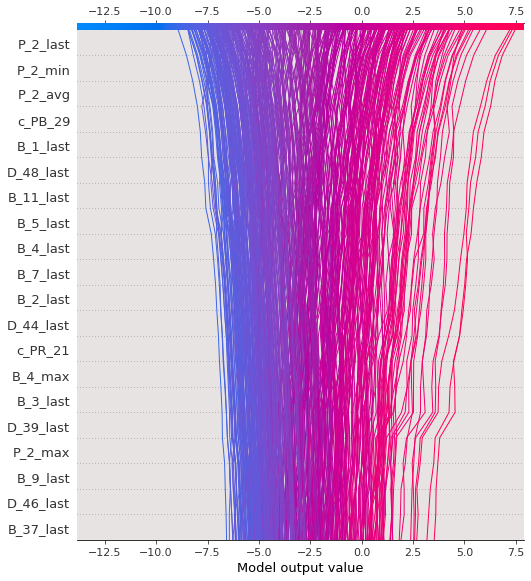

In [24]:
shap.decision_plot(expected_value, shap_values, features_display)

# visually this didn't change with the reduction in features, (but we're only looking at 20)
# There was no noticeable horizontal shift gains between the outputs
